In [1]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import random

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = 'mps' # solo para Mac serie M.

# Dataset de entrenamiento

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = datasets.FashionMNIST('data', download=True, transform=transform, train=True)
print('Tamaño dataset:', len(dataset))

labels = ['Camiseta/Top', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo', 'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Botín']
print('Cantidad de clases:', len(labels))

Tamaño dataset: 60000
Cantidad de clases: 10


x | Tipo: <class 'torch.Tensor'> - tamaño: torch.Size([1, 28, 28])
y | Tipo: <class 'int'> - valor: 4


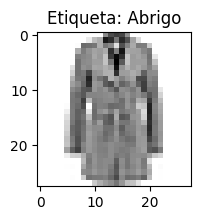

In [3]:
n = random.randint(0, len(dataset))
x, y = dataset[n]

print(f'x | Tipo: {type(x)} - tamaño: {x.shape}')
print(f'y | Tipo: {type(y)} - valor: {y}')

plt.figure(figsize = (2, 2))
plt.imshow(x.permute(1,2,0), cmap='gray_r')
plt.title(f'Etiqueta: {labels[y]}')
plt.show()

In [4]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

x, y = next(iter(dataloader))
print('Size x:', x.size())
print('Size y:', y.size())

Size x: torch.Size([32, 1, 28, 28])
Size y: torch.Size([32])


# Redes neuronales

## Red fully connected

In [5]:
class MLP(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = nn.ReLU()(self.fc1(x))
        x = nn.Softmax(dim=-1)(self.fc2(x))
        return x

In [6]:
# Ejemplo de uso:
input_dim, output_dim, hidden_dim = 64, 8, 32
mlp = MLP(input_dim, output_dim, hidden_dim)

batch_size = 256
x = torch.rand([batch_size, input_dim])    
y = mlp(x)

print('Dimensión x:', x.size())
print('Dimensión y:', y.size())

Dimensión x: torch.Size([256, 64])
Dimensión y: torch.Size([256, 8])


In [7]:
channels, width, height = dataset[0][0].size()
input_dim = channels * width * height
output_dim = len(labels)
hidden_dim = 16

mlp = MLP(input_dim, output_dim, hidden_dim)
summary(mlp, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]          12,560
            Linear-2                   [-1, 10]             170
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [8]:
def train(net, optimizer, dataloader, epochs):
    
    net.to(DEVICE)
    net.train()
    
    for epoch in range(epochs):

        for x, y in dataloader:
            
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            output = net(x)
            loss = nn.CrossEntropyLoss()(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [9]:
mlp_optimizer = torch.optim.Adam(mlp.parameters())
train(mlp, mlp_optimizer, dataloader, epochs=1)

In [10]:
def make_prediction(net):

    net.eval()
    
    indices = random.sample(range(len(dataset)), 10)
    plt.figure(figsize=(15, 6))
    
    with torch.no_grad():
        for i, idx in enumerate(indices, 1):
            x, y = dataset[idx]
            output = net(x.unsqueeze(0).to(DEVICE))
            label_pred = output[0].argmax()
            prob = output[0][label_pred].item()

            plt.subplot(2, 5, i)
            plt.imshow(x.permute(1, 2, 0), cmap='gray_r')
            plt.axis('off')
            plt.title(f'Etiqueta real: {labels[y]}\nPredicción: {labels[label_pred]} ({100*prob:.0f}%)')

        plt.tight_layout()
        plt.show()

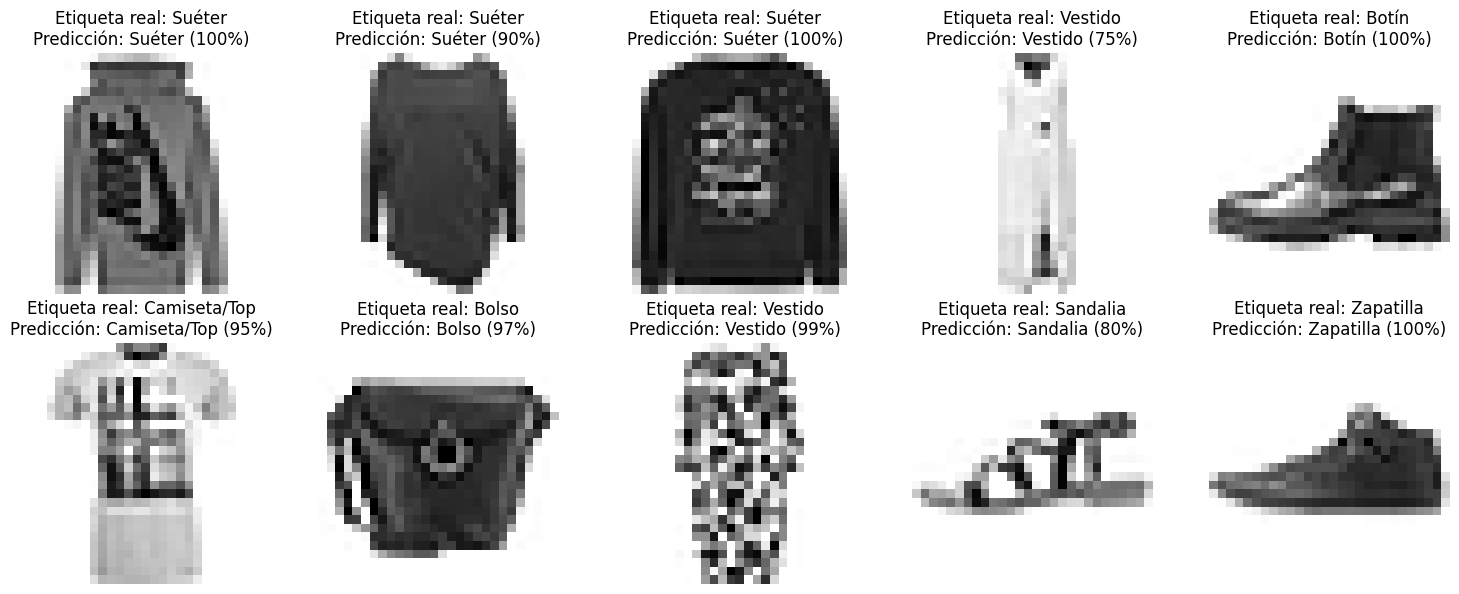

In [11]:
make_prediction(mlp)

## Red convolucional

In [12]:
class CNN(nn.Module):
    
    def __init__(self, img_resolution, n_channels, n_classes):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1, stride=1)
        self.fc = nn.Linear(in_features=12*img_resolution//(4*4), out_features=n_classes)
    
    def forward(self, x):
        x = nn.MaxPool2d(kernel_size=2)(nn.ReLU()(self.conv1(x)))
        x = nn.MaxPool2d(kernel_size=2)(nn.ReLU()(self.conv2(x)))
        x = nn.Flatten()(x)
        x = nn.Softmax(dim=-1)(self.fc(x))
        return x

In [13]:
channels, width, height = dataset[0][0].size()

cnn = CNN(img_resolution=width*height, n_channels=channels, n_classes=len(labels))
cnn_optimizer = torch.optim.Adam(cnn.parameters())
train(cnn, cnn_optimizer, dataloader, epochs=1)

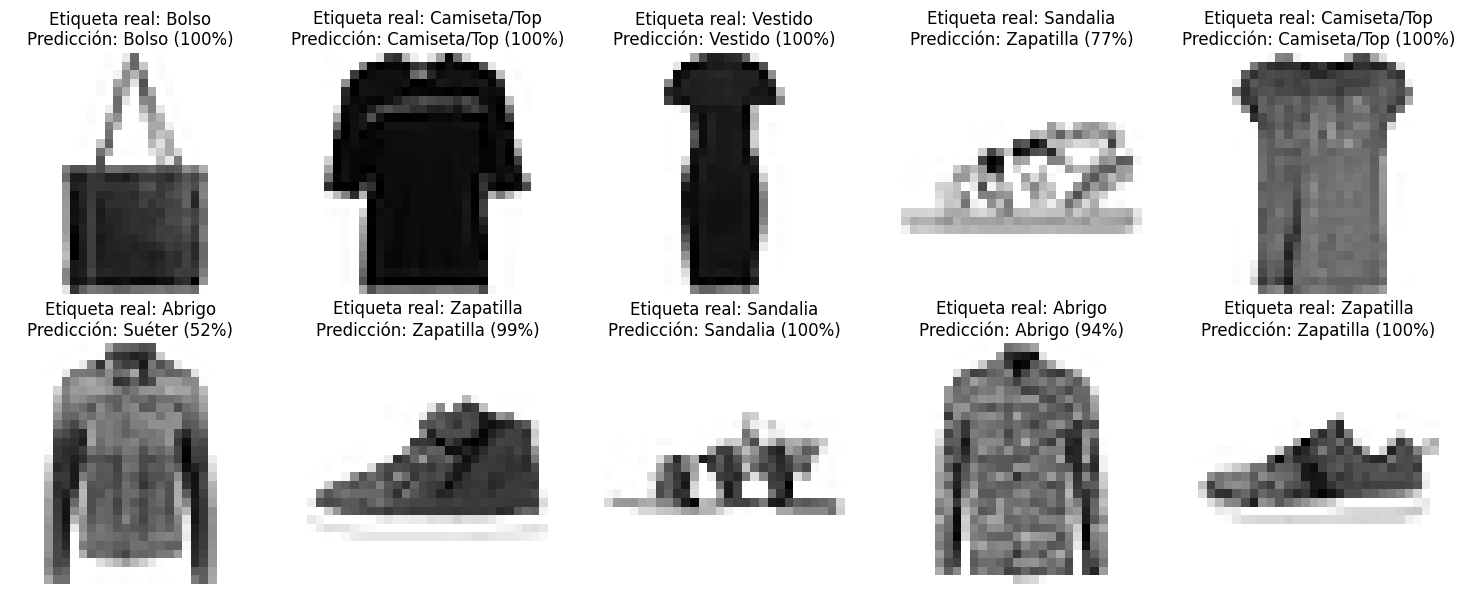

In [14]:
make_prediction(cnn)